In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
#import cv2 
import IPython
from glob import glob
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import tqdm
#import seaborn as sns
import albumentations as A
import torch
import torch.nn as nn
import timm
from torcheval.metrics import R2Score
import wandb
import torchvision


/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:

BASE_DIR = os.path.join(os.getcwd() , 'data')
train_df = pd.read_csv(BASE_DIR  +  '/train.csv')
TRAIN_VAL_SPLIT_SIZE = 0.2
TRAIN_BATCH_SIZE =128
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE  = 64
LEARNING_RATE = 1e-3
EPOCHS = 5
TIM_NUM_CLASS = 32
Normalize_transform_type = "log_transform"
RANDOM_NUMBER = 42
torch.manual_seed(RANDOM_NUMBER)

In [3]:
#wandb.login()

# wandb.init(project="cs680v2_normalized",
#     config={
#        "learning_rate": LEARNING_RATE,
#         "epochs": EPOCHS,
#         "batch_size" : TRAIN_BATCH_SIZE,
#     }
# )

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIRECTORY = os.path.join(os.getcwd(),"data")
torch.cuda.empty_cache()

In [5]:
EXTRA_COLOUMN = ['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg',
       'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       'SOIL_bdod_30.60cm_mean_0.01_deg',
       'SOIL_bdod_5.15cm_mean_0.01_deg',
       'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg',
       'SOIL_cec_100.200cm_mean_0.01_deg',
       'SOIL_cec_15.30cm_mean_0.01_deg', 'SOIL_cec_30.60cm_mean_0.01_deg',
       'SOIL_cec_5.15cm_mean_0.01_deg', 'SOIL_cec_60.100cm_mean_0.01_deg',
       'SOIL_cfvo_0.5cm_mean_0.01_deg',
       'SOIL_cfvo_100.200cm_mean_0.01_deg',
       'SOIL_cfvo_15.30cm_mean_0.01_deg',
       'SOIL_cfvo_30.60cm_mean_0.01_deg',
       'SOIL_cfvo_5.15cm_mean_0.01_deg',
       'SOIL_cfvo_60.100cm_mean_0.01_deg',
       'SOIL_clay_0.5cm_mean_0.01_deg',
       'SOIL_clay_100.200cm_mean_0.01_deg',
       'SOIL_clay_15.30cm_mean_0.01_deg',
       'SOIL_clay_30.60cm_mean_0.01_deg',
       'SOIL_clay_5.15cm_mean_0.01_deg',
       'SOIL_clay_60.100cm_mean_0.01_deg',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg',
       'SOIL_nitrogen_100.200cm_mean_0.01_deg',
       'SOIL_nitrogen_15.30cm_mean_0.01_deg',
       'SOIL_nitrogen_30.60cm_mean_0.01_deg',
       'SOIL_nitrogen_5.15cm_mean_0.01_deg',
       'SOIL_nitrogen_60.100cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_ocd_100.200cm_mean_0.01_deg',
       'SOIL_ocd_15.30cm_mean_0.01_deg', 'SOIL_ocd_30.60cm_mean_0.01_deg',
       'SOIL_ocd_5.15cm_mean_0.01_deg', 'SOIL_ocd_60.100cm_mean_0.01_deg',
       'SOIL_ocs_0.30cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg',
       'SOIL_phh2o_100.200cm_mean_0.01_deg',
       'SOIL_phh2o_15.30cm_mean_0.01_deg',
       'SOIL_phh2o_30.60cm_mean_0.01_deg',
       'SOIL_phh2o_5.15cm_mean_0.01_deg',
       'SOIL_phh2o_60.100cm_mean_0.01_deg',
       'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_sand_100.200cm_mean_0.01_deg',
       'SOIL_sand_15.30cm_mean_0.01_deg',
       'SOIL_sand_30.60cm_mean_0.01_deg',
       'SOIL_sand_5.15cm_mean_0.01_deg',
       'SOIL_sand_60.100cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg',
       'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg',
       'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg',
       'SOIL_silt_60.100cm_mean_0.01_deg', 'SOIL_soc_0.5cm_mean_0.01_deg',
       'SOIL_soc_100.200cm_mean_0.01_deg',
       'SOIL_soc_15.30cm_mean_0.01_deg', 'SOIL_soc_30.60cm_mean_0.01_deg',
       'SOIL_soc_5.15cm_mean_0.01_deg', 'SOIL_soc_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m11',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m12',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m3',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m4',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m5',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m6',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m7',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m8',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m9',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m9',
       'VOD_C_2002_2018_multiyear_mean_m01',
       'VOD_C_2002_2018_multiyear_mean_m02',
       'VOD_C_2002_2018_multiyear_mean_m03',
       'VOD_C_2002_2018_multiyear_mean_m04',
       'VOD_C_2002_2018_multiyear_mean_m05',
       'VOD_C_2002_2018_multiyear_mean_m06',
       'VOD_C_2002_2018_multiyear_mean_m07',
       'VOD_C_2002_2018_multiyear_mean_m08',
       'VOD_C_2002_2018_multiyear_mean_m09',
       'VOD_C_2002_2018_multiyear_mean_m10',
       'VOD_C_2002_2018_multiyear_mean_m11',
       'VOD_C_2002_2018_multiyear_mean_m12',
       'VOD_Ku_1987_2017_multiyear_mean_m01',
       'VOD_Ku_1987_2017_multiyear_mean_m02',
       'VOD_Ku_1987_2017_multiyear_mean_m03',
       'VOD_Ku_1987_2017_multiyear_mean_m04',
       'VOD_Ku_1987_2017_multiyear_mean_m05',
       'VOD_Ku_1987_2017_multiyear_mean_m06',
       'VOD_Ku_1987_2017_multiyear_mean_m07',
       'VOD_Ku_1987_2017_multiyear_mean_m08',
       'VOD_Ku_1987_2017_multiyear_mean_m09',
       'VOD_Ku_1987_2017_multiyear_mean_m10',
       'VOD_Ku_1987_2017_multiyear_mean_m11',
       'VOD_Ku_1987_2017_multiyear_mean_m12',
       'VOD_X_1997_2018_multiyear_mean_m01',
       'VOD_X_1997_2018_multiyear_mean_m02',
       'VOD_X_1997_2018_multiyear_mean_m03',
       'VOD_X_1997_2018_multiyear_mean_m04',
       'VOD_X_1997_2018_multiyear_mean_m05',
       'VOD_X_1997_2018_multiyear_mean_m06',
       'VOD_X_1997_2018_multiyear_mean_m07',
       'VOD_X_1997_2018_multiyear_mean_m08',
       'VOD_X_1997_2018_multiyear_mean_m09',
       'VOD_X_1997_2018_multiyear_mean_m10',
       'VOD_X_1997_2018_multiyear_mean_m11',
       'VOD_X_1997_2018_multiyear_mean_m12']


In [6]:
from sklearn.preprocessing import StandardScaler
SCALAR = StandardScaler()

def create_val_train_dataset(BASE_DIR,train_split_size,scalar:StandardScaler):
    df = pd.read_csv(BASE_DIR  +  '/train.csv')
    df["image_path"] = BASE_DIR + "/train_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
    
    # standardize the dataset
    scalar.fit(df[EXTRA_COLOUMN])
    df[EXTRA_COLOUMN] = scalar.transform(df[EXTRA_COLOUMN])
    train_df , val_df = train_test_split(df,test_size=train_split_size,shuffle=True)
    train_df.reset_index(drop=True , inplace  = True)
    val_df.reset_index(drop = True , inplace = True)
    return  train_df , val_df
def create_test_dataset(BASE_DIR,scalar):
    df = pd.read_csv(BASE_DIR  +  '/test.csv')
    df["image_path"] = BASE_DIR + "/test_images/" + df["id"].astype(str) + ".jpeg"   # add images in the training dataframe
    df[EXTRA_COLOUMN] = scalar.transform(df[EXTRA_COLOUMN])
    return df

train_df , val_df = create_val_train_dataset(BASE_DIR,TRAIN_VAL_SPLIT_SIZE,scalar = SCALAR)
test_df = create_test_dataset(BASE_DIR,scalar=SCALAR)

In [7]:
class NormalizeOutput():
    def __init__(self,type_transform ):
        self.transform = type_transform
        self.mean = 0
        self.std = 0
        self.mean_tensor = 0
        self.std_tensor = 0
        
        pass
    def normalize(self,df):
        if self.transform == "log_transform":
            mean = np.log10(df).mean()
            std = np.log10(df).std()
            self.mean = mean
            self.std = std
            self.mean_tensor = torch.Tensor(self.mean.values).to(DEVICE)
            self.std_tensor = torch.Tensor(self.std.values).to(DEVICE)
            return (np.log10(df) - self.mean)/self.std
    def denormalize(self,df):
        if self.mean is None or self.std is None :
            raise Exception("mean and/std is not defined ")
        if self.normalize == "log_transform":
            df_denormalize =10**((df*self.std) + self.mean )
            return df_denormalize
    def denormalize_tensor(self,batch) :
        if self.mean_tensor is None or self.std_tensor is None :
            raise Exception("mean and/std is not defined ")
        if self.transform == "log_transform":
            df_denormalize =10**((batch*self.std_tensor) + self.mean_tensor )
            return df_denormalize
            

In [8]:
#img = plt.imread(val_df["image_path"].iloc[0])
# plt.imshow(img)
# img.shape
#train_df.columns

In [9]:
# to avoid overfitting : 1) try diffferent transformations 2) batch norm 3)  dropout  4)

In [10]:
class data_loader(Dataset ):
    def __init__(self,df , is_val = False,normalizedOutput=None, extra_params = False ):
        global EXTRA_COLOUMN
        self.df = df.copy()
        if normalizedOutput == None:
            pass
        else :
            if not is_val :
                self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]] = normalizedOutput.normalize(self.df[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]])
        print("outside pass")
        self.transform =torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                                 #torchvision.transforms.Resize((384,384)),
                                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                    torchvision.transforms.RandomVerticalFlip(p=0.5),
                                    torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                    torchvision.transforms.RandomChoice([
                                        torchvision.transforms.Lambda(lambda x : x + np.sqrt(0.1)*torch.randn_like(x)),
                                        torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x)),
                                        torchvision.transforms.Lambda(lambda x : x + torch.randn_like(x))])
                             ])
    
        self.extra_params = extra_params
        self.extra_coloumns = EXTRA_COLOUMN
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self , index):
        row = self.df.iloc[index]
        image = plt.imread(row["image_path"])
        image = np.copy(image)
        traits = row[['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean' ]].values.astype(np.float32)
        traits = torch.tensor(traits,dtype=torch.float32)
        if self.transform :
            image = self.transform(image)
            #image = torch.permute(image  )
        if self.extra_params:
            extras = row[self.extra_coloumns].values.astype(np.float32)
            return image , traits  , torch.tensor(extras,dtype=torch.float32)
        return  image , traits
normalize_function = NormalizeOutput(Normalize_transform_type)
train_dataset = data_loader(train_df, is_val = False,normalizedOutput=normalize_function ,extra_params=True)
val_dataset  = data_loader(val_df,   is_val = True,normalizedOutput=normalize_function , extra_params=True)    

train_dataloader = DataLoader(train_dataset , batch_size = TRAIN_BATCH_SIZE , shuffle=True )
val_dataloader = DataLoader(val_dataset , batch_size =  VAL_BATCH_SIZE , shuffle=False )

outside pass
outside pass


In [11]:
# class data_loader_test(Dataset ):
#     def __init__(self,df ,extra_params = False ):
#         global EXTRA_COLOUMN
#         self.df = df.copy()
#         self.transform =torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                  #torchvision.transforms.Resize((384,384)),
#                                   torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#                                   ])
    
#         self.extra_params = extra_params
#         self.extra_coloumns = EXTRA_COLOUMN
#     def __len__(self):
#         return len(self.df)    
#     def __getitem__(self , index):
#         row = self.df.iloc[index]
#         image = plt.imread(row["image_path"])
#         image = np.copy(image)
#         if self.transform :
#             image = self.transform(image)
#         if self.extra_params:
#             extras = np.copy(row[self.extra_coloumns]).values.astype(np.float64)
#             return image  , torch.Tensor(extras)
#         return  image 
# test_dataset = data_loader_test(test_df)
# test_dataloader = DataLoader(test_dataset,batch_size =TEST_BATCH_SIZE,shuffle=False)

# def predict_test(test_dataset , model):
#     predictions = []
#     for i in test_dataset:
#         model.eval()
#         prediction = model(i.to(DEVICE))
#         prediction  = normalize_function.denormalize_tensor(prediction)
#         predictions.extend(prediction.detach().cpu().numpy())
#     predictions = np.array(predictions)
#     output = np.reshape(predictions,(-1,predictions.shape[-1]))
#     return pd.DataFrame(output , columns=['X4', 'X11', 'X18', 'X26', 'X50', 'X3112' ])
# output = predict_test(test_dataloader , model)
# output = pd.concat([test_df["id"],output],axis=1 )
# #output.to_csv()

In [12]:
class R2Loss(nn.Module):
    def __init__(self, num_classes=6):
        super(R2Loss, self).__init__()
        # Initialize learnable weights for each class, one weight per class
        # self.class_weights = nn.Parameter(torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32))
        # Increase weight for X_26_mean

    def forward(self, y_pred, y_true):
        # Calculate residual sum of squares per class
        SS_res = torch.sum((y_true - y_pred) ** 2, dim=0)  # (B, C) -> (C,)
        # Calculate total sum of squares per class
        SS_tot = torch.sum(
            (y_true - torch.mean(y_true, dim=0)) ** 2, dim=0
        )  # (B, C) -> (C,)
        # Calculate R2 loss per class, avoiding division by zero
        r2_loss =SS_res / (SS_tot + 1e-6)  # (C,)
        # Weight the R2 loss by the learnable class weights
        # weighted_r2_loss = self.class_weights * r2_loss
        # Return the mean of the weighted R2 loss
        return torch.mean(r2_loss)
def initialize_timm_model( model_name   , num_class):
    model_ft  = None
    if model_name == "resnet34" :
        """ Resnet34 """
        model = timm.create_model('resnet34' , num_classes=num_class )
        return model
    # if model_name == "Swin_Transformer":
    #     model = timm.create_model('swin_large_patch4_window12_384.ms_in22k_ft_in1k' , num_classes = 6 , pretrained=True)
    #     return model 
    if model_name =="convnextv2":
        model = timm.create_model('convnext_tiny.in12k_ft_in1k_384',num_classes=num_class)
        return model 
    
    if model_name == "efficientnet":
        model = timm.create_model("efficientnet_b0",pretrained = True)
        # for param in model.parameters():
        #         param.requires_grad = False
        # model.conv_head.trainable = True
        # model.blocks[-1].trainable = True
        # model.bn2.trainable = True
        model.classifier = nn.Sequential(
            nn.Linear(in_features=1280, out_features=768, bias=True),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(in_features=768, out_features=256, bias=True),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(in_features=32, out_features=num_class, bias=True),
        )
        return model

class CustomModel(nn.Module):
    
    def __init__(self,input_channels,tim_num_class , model):
        super().__init__()
        # if model =="resnet34":
        self.backbone = initialize_timm_model(model_name=model ,num_class=tim_num_class)
        self.extra_parameters_models = nn.Sequential(
            nn.Linear(input_channels,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,16),
        )
        self.output = nn.Sequential(
            nn.Linear(tim_num_class+16,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,6)
        )
        
    def forward(self,image,x):
        output_image = self.backbone(image) # bach * (hight*col)
        z = self.extra_parameters_models(x) # batch * 16
        inputs  = torch.cat((output_image,z), 1 )
        output = self.output(inputs)
        return output

def get_model_optimizer_lossFunction(model_name,learning_rate,extra_params = False):
    global DEVICE
    if extra_params:
        model = CustomModel(input_channels=len(EXTRA_COLOUMN),tim_num_class= TIM_NUM_CLASS, model=model_name)
    else:
        model = initialize_timm_model(model_name=model_name , TIM_NUM_CLASS = 6)    
    model.to(device = DEVICE)
    loss_function = R2Loss()
    loss_function.to(device=DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    #scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1 , patience=1 , verbose = True )
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR( optimizer , T_max = 5, eta_min= 1e-5  )
    # optimizer.to(device = DEVICE)
    return model,optimizer,loss_function , scheduler
class BestModelSaveCallback:
    def __init__(self, save_path):
        self.save_path = save_path
        self.best_accuracy = -1

    def __call__(self, accuracy,model):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            model.to(device = "cpu")
            torch.save(model.state_dict(), self.save_path)
            model.to(device=DEVICE)


In [13]:
def train_batch(inputs,model,loss_function,optimizer,extra_params = False):
    model.train()  
    if extra_params :
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)        
        
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)    
        prediction = model(x)
    
    
    loss = loss_function(prediction,y)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.detach().cpu().numpy()

@torch.no_grad
def do_prediction(inputs,model, is_val=False , extra_params = False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if extra_params:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    if is_val :
        prediction = normalize_function.denormalize_tensor(batch=prediction)
    return prediction.detach().cpu().numpy()

@torch.no_grad()
def validation_loss_batch(inputs,model,loss_function,extra_params=False):
    global Train_std_tensor , Train_mean_tensor
    model.eval()
    if extra_params:
        x,y,z = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        z = z.to(DEVICE)
        prediction = model(x,z)
    else:
        x,y = inputs
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = model(x)
    prediction = normalize_function.denormalize_tensor(batch=prediction)
    loss = loss_function(prediction, y)
    return loss.detach().cpu().numpy()

def utils_convert_to_2d_tensors(predictions,targets):
    predictions  = np.array(predictions)
    targets = np.array(targets)
    predictions  = np.reshape(predictions , (-1, predictions.shape[-1]))
    targets  = np.reshape(targets  , (-1 , targets.shape[-1]))
    return torch.Tensor(predictions), torch.Tensor(targets)

def train(trainLoader,valLoader,model,optimizer,loss_function,epochs,best_model_callback,extra_params=False):
    #wandb.watch(model,loss_function,log = "all",log_freq=50)
    
    train_epoch_loss , train_epoch_accuracy =[] , []
    val_epoch_loss , val_epoch_accuracy = [],[]
    
    
    for epoch in range(epochs):
        print(f"epoch: {epoch} , lr is { scheduler.get_last_lr()}" )
        train_loss  = [] 
        val_loss ,val_accuracy = [] , []
        
        # batch training loss
        with tqdm.tqdm(total=len(trainLoader)) as trainingLoop:
            for index,batch in enumerate(iter(trainLoader)): 
        
                loss = train_batch(batch,model,loss_function,optimizer,extra_params=extra_params)
                train_loss.append(loss)

                trainingLoop.set_description(f"Batch: {index}/{len(trainLoader)}")
                trainingLoop.set_postfix({"training Loss " : loss})
                trainingLoop.update(1)
                ##wandb.log({"Training Loss":loss })
        train_loss  = np.array(train_loss).mean() 
        train_epoch_loss.append(train_loss)
        
        # find training accuracy 
        predictions,targets = [],[]
        for index,batch in enumerate(iter(trainLoader)): 
        
            prediction = do_prediction(batch,model,extra_params=extra_params)
            predictions.extend(prediction)
            targets.extend(batch[1].detach().cpu().numpy())
           
        
        predictions = np.array(predictions)
        targets = np.array(targets)
        predictions , targets = utils_convert_to_2d_tensors(predictions , targets)
        # print("predictions=", predictions[0:2])
        # print("targets=",targets[0:2])
        metric = R2Score()
        metric.update(predictions , targets)
        train_epoch_accuracy.append(metric.compute().detach().cpu().numpy())
                
        
        # validation set loss & accuracy  
        predictions,targets = [],[]
        with tqdm.tqdm(total = len(valLoader)) as validationLoop:
            for index,batch in enumerate(iter(valLoader)):
                
                loss = validation_loss_batch(batch,model,loss_function,extra_params=extra_params)
                val_loss.append(loss)
                prediction = do_prediction(batch,model,is_val=True,extra_params=extra_params)
                predictions.extend(prediction)
                targets.extend(batch[1].detach().cpu().numpy())
                
                validationLoop.set_description(f"Batch: {index}/{len(valLoader)}")
                validationLoop.set_postfix({"Validation loss " : loss}) 
                ##wandb.log({"Vlaidation loss" : loss})
                #wandb.log({"Validation Loss ": val_loss.item()})
                validationLoop.update(1)
        
        
        val_loss  = np.array(val_loss).mean() 
        val_epoch_loss.append(val_loss)
        
        predictions = np.array(predictions)
        targets = np.array(targets)
        # print("predictions-val=", predictions[0:2])
        # print("targets-val=",targets[0:2])
        metric = R2Score()
        predictions , targets = utils_convert_to_2d_tensors(predictions , targets)
        metric.update(predictions , targets)
        val_epoch_accuracy.append(metric.compute().detach().cpu().numpy().item())
        
        scheduler.step(val_loss)
        
        print(f"epoch:{epoch}, Training (avg) loss : {train_loss} , Validation loss (avg) = {val_loss}")
        best_model_callback(metric.compute().detach().cpu().numpy().item(),model)        # save the best model according to the validation accuracy
        
        
    return train_epoch_loss,val_epoch_loss,train_epoch_accuracy , val_epoch_accuracy






In [14]:
model = CustomModel(len(EXTRA_COLOUMN),6 , "resnet34")
image = torch.ones(10,3,128,128)

# x-shape= torch.Size([10, 3, 128, 128]) z-shape= torch.Size([10, 163]
x = torch.ones(10,len(EXTRA_COLOUMN))
model(image,x).shape

torch.Size([10, 6])

In [15]:

model,optimizer,loss_function,scheduler = get_model_optimizer_lossFunction(model_name = "efficientnet",learning_rate = LEARNING_RATE,extra_params=True)
best_model_callback = BestModelSaveCallback(save_path=os.path.join(BASE_DIR,'best_model_transformation_convnextv2.pth'))
train_losses, val_losses , train_accuracies,val_accuracies = train(train_dataloader,val_dataloader,model,optimizer,loss_function,EPOCHS,best_model_callback,extra_params=True)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


epoch: 0 , lr is [0.001]


Batch: 135/136: 100%|██████████| 136/136 [00:13<00:00, 10.34it/s, Validation loss =0.96531963]
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch:0, Training (avg) loss : 1.0211273431777954 , Validation loss (avg) = 0.8929155468940735
epoch: 1 , lr is [0.0009241188141393133]


Batch: 135/136: 100%|██████████| 136/136 [00:13<00:00, 10.37it/s, Validation loss =0.9958291] 
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch:1, Training (avg) loss : 0.8494212031364441 , Validation loss (avg) = 0.8564980626106262
epoch: 2 , lr is [0.000930034976057558]


Batch: 135/136: 100%|██████████| 136/136 [00:13<00:00, 10.43it/s, Validation loss =0.9403278] 
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch:2, Training (avg) loss : 0.8322749137878418 , Validation loss (avg) = 0.8341748714447021
epoch: 3 , lr is [0.0009335516483412465]


Batch: 135/136: 100%|██████████| 136/136 [00:13<00:00, 10.36it/s, Validation loss =1.0075201] 
/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch:3, Training (avg) loss : 0.8733612895011902 , Validation loss (avg) = 0.9420301914215088
epoch: 4 , lr is [0.0009157930102802942]


Batch: 135/136: 100%|██████████| 136/136 [00:13<00:00, 10.42it/s, Validation loss =2.8429925]

epoch:4, Training (avg) loss : 8.107339859008789 , Validation loss (avg) = 3.9864537715911865



/home/prajwal/anaconda3/envs/pytorch_gpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [16]:

# predictions= torch.tensor([[ 1.2391, 30.3367, 30.3599, 29.7099, 20.0526, 31.2610],
#         [ 1.2679, 30.3845, 30.3134, 29.7083, 20.3929, 31.2463]])
# targets= torch.tensor([[1.1125e+00, 1.4686e+02, 1.9699e+04, 3.4597e+03, 1.5282e+01, 3.9792e+05],
#         [9.7378e-01, 1.5390e+02, 1.9702e+04, 3.4673e+03, 1.4737e+01, 3.9847e+05]])
# metric = R2Score()
# metric.update(predictions , targets)
# metric.compute()





# from sklearn.metrics import r2_score
# predictions= np.array([[ 1.2391, 30.3367, 30.3599, 29.7099, 20.0526, 31.2610],
#         [ 1.2679, 30.3845, 30.3134, 29.7083, 20.3929, 31.2463]])
# targets= np.array([[1.1125e+00, 1.4686e+02, 1.9699e+04, 3.4597e+03, 1.5282e+01, 3.9792e+05],
#         [9.7378e-01, 1.5390e+02, 1.9702e+04, 3.4673e+03, 1.4737e+01, 3.9847e+05]])
# r2_score(y_true = targets , y_pred =predictions)



# targets = torch.tensor([[0.0, 2.0], [1.0, 6.0]])
# predictions = torch.tensor([[0.0, 1.0], [2.0, 5.0]])
# torch.mean(1- (torch.sum((targets - predictions)**2,axis=0)/torch.sum((targets - targets.mean())**2,axis=0)))


# metric = R2Score()
# # input = torch.tensor([[0, 2], [1, 6]])
# # target = torch.tensor([[0, 1], [2, 5]])
# input = torch.tensor([[ 1.2391, 30.3367, 30.3599, 29.7099, 20.0526, 31.2610],
#         [ 1.2679, 30.3845, 30.3134, 29.7083, 20.3929, 31.2463]])
# target= torch.tensor([[1.1125e+00, 1.4686e+02, 1.9699e+04, 3.4597e+03, 1.5282e+01, 3.9792e+05],
#         [9.7378e-01, 1.5390e+02, 1.9702e+04, 3.4673e+03, 1.4737e+01, 3.9847e+05]])
# metric.update(input, target)
# metric.compute()

In [17]:
def Plot(train_losses,train_accuracies,val_losses,val_accuracies,path):
    plt.plot(train_losses,label = "train loss")
    plt.plot(val_losses,label = "validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig(os.path.join(path,"Loss.png"))
    #wandb.log({"Loss": plt})

    plt.plot(val_accuracies,label = "validation accuracy")
    plt.plot(train_accuracies,label = "train accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend() 
    #plt.savefig(os.path.join(path,"Accuracy.png"))
    #wandb.log({"Accuracy": plt})

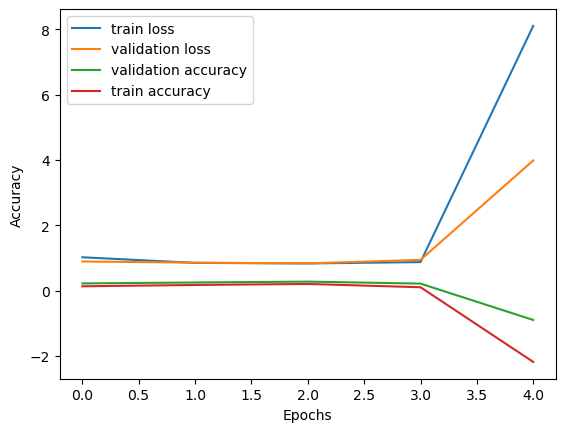

In [18]:
Plot(train_losses,train_accuracies,val_losses,val_accuracies,path = BASE_DIR)